In [1]:
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from skimage import color
from PIL import Image
import re

#python library for reading raster data 
import rasterio

from openpiv import tools, pyprocess, preprocess, validation, filters, scaling

In [2]:
# configure plotting

import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable #for subplot colorbars
from matplotlib.pyplot import cm

%config InlineBackend.rc = {'figure.dpi': 300, 'savefig.dpi': 300, \
                            'figure.figsize': (6, 6 / 1.6), 'font.size': 8, \
                            'figure.facecolor': (1, 1, 1, 0),'font.sans-serif':'Latin Modern Math'}

from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

%matplotlib inline

#dark plotting
# plt.style.use('dark_background')

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [4]:
def get_date(time):
    d = re.findall(r'\d+', image_names[time])
    d = d[0]
    return d

In [5]:
def get_datestring(date):
    
    my_datetime = date
    my_datetime = datetime.strptime(my_datetime, "%Y%m%d")
    datetime_string = my_datetime.strftime("%B %d, %Y") 

    return datetime_string

In [6]:
#computing $\Delta$t from survey dates
from datetime import datetime

def days_between(t1, t2):
    
    d1 = image_names[t1]
    d2 = image_names[t2]

    # d1 = d1.replace('.tif', '')
    # d2 = d2.replace('.tif', '')

    # extracting date from image names
    d1 = re.findall(r'\d+', image_names[t1])
    d2 = re.findall(r'\d+', image_names[t2])

    #ensuring result is a string not a list
    d1 = d1[0]
    d2 = d2[0]
    
    d1 = datetime.strptime(d1, "%Y%m%d")
    d2 = datetime.strptime(d2, "%Y%m%d")
    
    return abs((d2 - d1).days)

In [7]:
def process_image(time):
    
    "this function loads and processes an image at a designated time"

    src = rasterio.open(image_names[time])
    #making a numpy array
    image = src.read()
    image = image[0].astype(np.int32)
    image_scaled = np.array(image/np.amax(image)*255, np.int32) #scaling pixel values to range from 0-255

    image_stdize = preprocess.standardize_array(image) #standardizing array 

    return image_stdize

# Reading data

## Landslide polygon from kml

In [8]:
# loading kml

from bs4 import BeautifulSoup
import csv

infile = '/Volumes/Elements/Projects/EarthPIV/MudCreek/Data/MudCreek_PreFailPolygon.kml'
outfile = '/Volumes/Elements/Projects/EarthPIV/MudCreek/Data/MudCreek_PreFailPolygon.csv'

with open(infile, 'r') as f:
    
    s = BeautifulSoup(f, 'xml')
    
    with open(outfile, 'wb') as csvfile:
        writer = csv.writer(csvfile)
        for coords in s.find_all('coordinates'):
            
            # Take coordinate string from KML and break it up into [Lat,Lon,Lat,Lon...] to get CSV row
            space_splits = coords.string.split(" ")

#some extra characters are added onto the first coordinate entry, here i am removing them
mudcreek_polygon_coordinates = ([s.strip('\n\t\t\t\t\t\t') for s in space_splits])

#empty list to store coordinates
mudcreek_polygon_x = []
mudcreek_polygon_y = []

for t in range(len(mudcreek_polygon_coordinates)-1):
    split = mudcreek_polygon_coordinates[t].split(",")
    mudcreek_polygon_x.append(float(split[0]))
    mudcreek_polygon_y.append(float(split[1]))

mudcreek_polygon_XY = zip(mudcreek_polygon_x,mudcreek_polygon_y)
mudcreek_polygon_XY = list(mudcreek_polygon_XY)

## Handwerger-provided geocoded SLC .tiff images

In [9]:
## drop working directory with location of downloaded images here
os.chdir('/Volumes/Elements/Projects/EarthPIV/MudCreek/Data/T42D/')

# reading all images into memory is not efficient for the iterative loops
# so we read in a list of filenames within the directory that houses the images

#libraries for reading and sorting
import glob
import natsort

#empty list to fill with image names
image_names = []

for name in glob.glob('geo_*.tif'):
    image_names.append(name)

#using natsort to overcome the varying digit numbers i.e. 1 10 100
image_names = natsort.natsorted(image_names, reverse=False)

In [10]:
src = rasterio.open(image_names[1])
#making a numpy array
array = src.read()
array = array[0].astype(np.int32)
array_scaled = np.array(array/np.amax(array)*255, np.int32) #scaling pixel values to range from 0-255

/var/folders/d0/k1rwv06963ld8bhgl23fj_9w0000gn/T/ipykernel_30359/2387982930.py:4: RuntimeWarning: invalid value encountered in cast
  array = array[0].astype(np.int32)


## A list of date times from image names

In [11]:
def get_date(time):
    d = re.findall(r'\d+', image_names[time])
    d = d[0]
    return d

In [12]:
dates = []

for i in range(len(image_names)):
    dates.append(get_date(i))

# Plotting the images

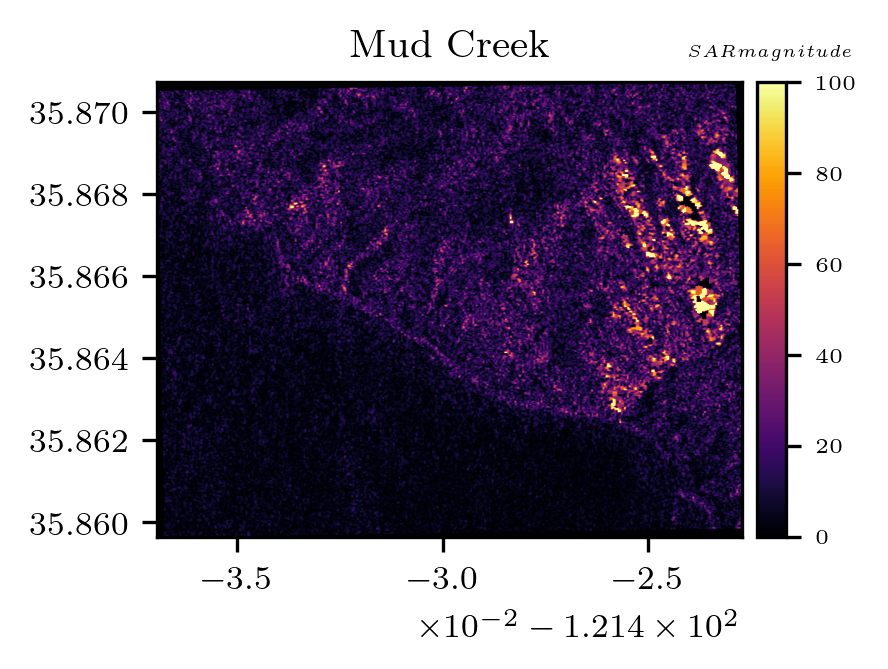

In [13]:
#this extent is read from "reading_geotiff.ipyb", the coordinates are read from and then transformed from the .tiff metadata
extent = [-121.43695098488001,-121.42271597462143, 35.859656738480055,35.87071500741607]

fig, (ax1) = plt.subplots(1, 1, figsize=(3, 3))

vmin = 0
vmax = 100

cmap = 'inferno'

im1 = ax1.imshow(array_scaled,cmap = cmap,vmin = vmin,vmax = vmax,extent = extent)

# ax1.plot(mudcreek_polygon_x,mudcreek_polygon_y,'k')
ax1.set_aspect(1)
ax1.set_title('Mud Creek')
# ax1.set_xlabel(r'lat')
# ax1.set_ylabel(r'long')

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1,cax=cax1,orientation='vertical')
cax1.tick_params(labelsize=5)
cax1.set_title(r'$SAR magnitude$', fontsize=4)

fig.tight_layout()

# openPIV

In [14]:
def openpiv_default_run(im1, im2,dt):
    """ default settings for OpenPIV analysis using
    extended_search_area_piv algorithm for two images
    
    Inputs:
        im1,im2 : str,str = path of two image
    """

    ###################################################################################################################
    u0, v0, sig2noise = pyprocess.extended_search_area_piv(
        im1.astype(np.int32),
        im2.astype(np.int32),
        window_size=winsize,
        overlap=overlap,
        dt=dt,
        search_area_size=searchsize,
        sig2noise_method='peak2mean')
    ###################################################################################################################
    #getting coordinates
    x, y = pyprocess.get_coordinates(image_size=im1.shape,
                                     search_area_size=searchsize,
                                     overlap=overlap)
    ######################################################################################
    # convert x,y to m
    # convert u,v to m/day

    x, y, u, v = scaling.uniform(
        x,
        y,
        u0,
        v0,
        scaling_factor= 1, 
    )

    # 0,0 shall be bottom left, positive rotation rate is counterclockwise
    x, y, u, v = tools.transform_coordinates(x, y, u, v)
    
    return x, y, u, v, sig2noise

## Loop

In [15]:
winsize = 32 * 3 # pixels, interrogation window size in frame A
searchsize = 36 *3  # pixels, search area size in frame B
overlap = 30 *3# pixels, (50% overlap is given as a target in the openpiv tutorial, here i crank it up)

In [16]:
piv = [[] for _ in range(len(image_names)-1)] #an empty list in which to store the displacement vectors

for i in range(len(image_names)-1):

    t1 = i
    t2 = i+1

    dt = days_between(t1, t2) # using the days between function to compute dt

    frame_t1 = process_image(t1)
    frame_t2 = process_image(t2)
        
    #doing the actual PIV between the two designated frames
    x, y, u, v, sig2noise = openpiv_default_run(frame_t1,frame_t2,dt = dt)

    # converting from pixels/day to m/day
    u = u * 3
    v = v * 3

    piv[i] = (x, y, u, v, sig2noise)

/var/folders/d0/k1rwv06963ld8bhgl23fj_9w0000gn/T/ipykernel_30359/3033945100.py:8: RuntimeWarning: invalid value encountered in cast
  image = image[0].astype(np.int32)


In [17]:
## selecting x,y,u,v for particular (tw,tau) pair
t = 59

data = piv
data = np.asarray(data)

x = data[t][0]
y = data[t][1]
u = data[t][2]
v = data[t][3]

sig2noise = piv[t][4]
velocity_map = np.sqrt(u**2+v**2)

In [18]:
#making array of pixel coordinates in UTM that span the length of the original image
#i'm pretty sure this is correct, but when overlaying the quivers with the maps below, i think i might be off by some small
#factor (october 28th 2023)
image = frame_t2

x_utm = np.linspace(-121.43695098488001,-121.42271597462143, image.shape[1],dtype='float64')
y_utm = np.linspace(35.859656738480055,35.87071500741607,image.shape[0],dtype='float64')

#finding the pixel spacing in UTM
dy = y_utm[1] - y_utm[0]
dx = x_utm[1] - x_utm[0]

offset_x = -121.43695098488001
offset_y = 35.859656738480055

x_rescale,y_rescale = x * dx + offset_x, y * dy + offset_y

In [19]:
from matplotlib import path

#rescaling coordinates to UTM
x_rescale,y_rescale = x * dx + offset_x, y * dy + offset_y

XY = list(zip(mudcreek_polygon_x, mudcreek_polygon_y))
# XY = xy

p = path.Path(XY)  
xv = x_rescale
yv = y_rescale
flags = p.contains_points(np.hstack((xv.flatten()[:,np.newaxis],yv.flatten()[:,np.newaxis])))
mudcreek_mask = np.reshape(flags,(x.shape))

In [20]:
#masking velocity vectors to those within landslide polygon
x_mudcreek_mask = ma.masked_array(x_rescale, mask=~mudcreek_mask)
y_mudcreek_mask = ma.masked_array(y_rescale, mask=~mudcreek_mask)
u_mudcreek_mask = ma.masked_array(u, mask=~mudcreek_mask)
v_mudcreek_mask = ma.masked_array(v, mask=~mudcreek_mask)

#masking velocity map
velocity_mask = ma.masked_array(velocity_map, mask=~mudcreek_mask)

#masking sig2noise map
s2n_mask = ma.masked_array(sig2noise, mask=~mudcreek_mask)

#to see the pixel size of the velocity and s2n maps
# frame_a.shape[0] / velocity_map.shape[0], frame_a.shape[1] / velocity_map.shape[1]

In [21]:
#converting the date from numerical to string so that it can be printed
t1_datename = dates[t]
t2_datename = dates[t+1]

numerical_datetime_1 = image_names[t]
numerical_datetime_1 = numerical_datetime_1.replace('.tif', '')
numerical_datetime_2 = image_names[t+1]
numerical_datetime_2 = numerical_datetime_2.replace('.tif', '')

In [22]:
## i suppose if i want to save data it would be here

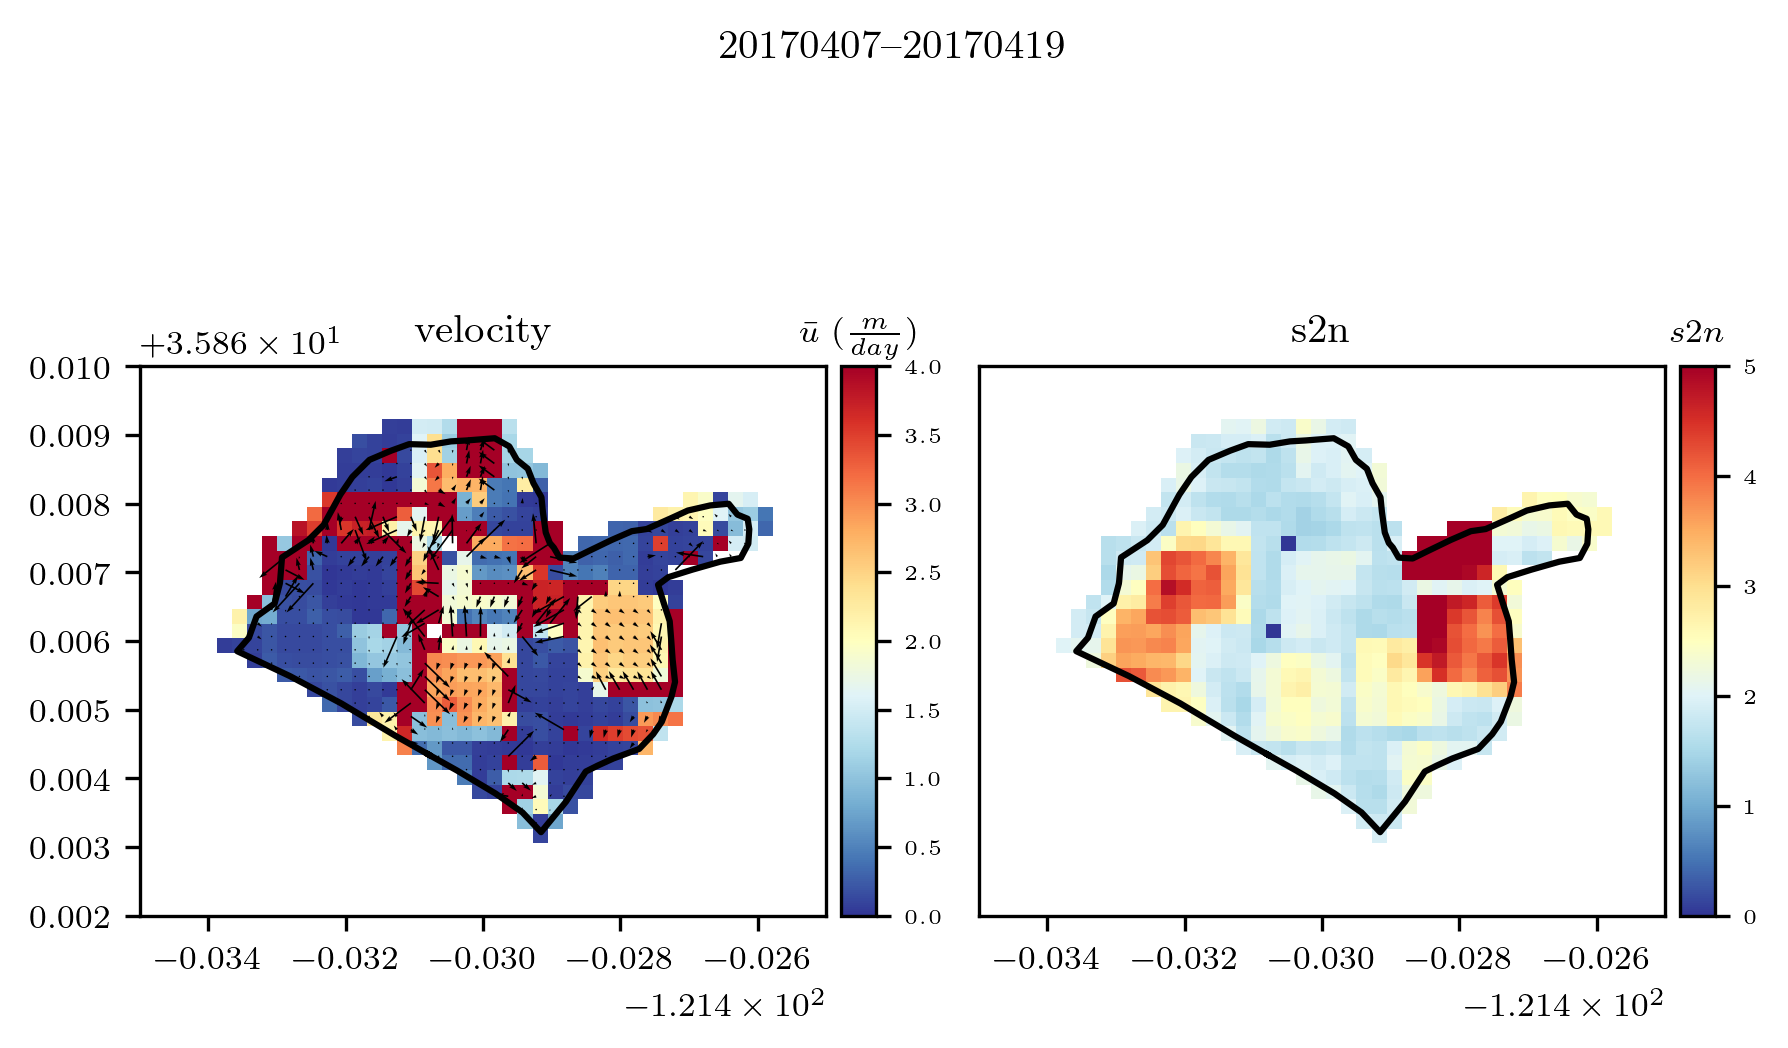

In [23]:
cmap = 'RdYlBu_r'
velocity_vmin = 0
velocity_vmax = 4

s2n_vmin = 0
s2n_vmax = 5

# scale = 200
scale = np.nanmean(velocity_mask) * 100

factor = -1.214e2

fig = plt.figure(figsize=(6, 4))
ax_vel = plt.subplot(121)
ax_s2n = plt.subplot(122)

# Display image
# vel_img = ax_vel.imshow(array[0],extent = extent, cmap = cmap,alpha = 1)
vel_img = ax_vel.imshow(velocity_mask,vmin = velocity_vmin,vmax = velocity_vmax,extent = extent, cmap = cmap,alpha = 1)

# s2n_img = ax_s2n.imshow(array[0],extent = extent, cmap = cmap,alpha = 1)
s2n_img = ax_s2n.imshow(s2n_mask,vmin = s2n_vmin,vmax = s2n_vmax,extent = extent, cmap = cmap,alpha = 1)

# Draw landslide polygon
ax_vel.plot(mudcreek_polygon_x,mudcreek_polygon_y,'k')
ax_s2n.plot(mudcreek_polygon_x,mudcreek_polygon_y,'k')


# Draw velocity vectors
ax_vel.quiver(x_mudcreek_mask,y_mudcreek_mask,u_mudcreek_mask,v_mudcreek_mask,scale = scale,color = 'k')

fig.suptitle(t1_datename + "--"+ t2_datename) # or plt.suptitle('Main title')
fig.subplots_adjust(top=0.88)
                    
divider = make_axes_locatable(ax_vel)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(vel_img,cax=cax1,orientation='vertical')
cax1.tick_params(labelsize=5)
cax1.set_title(r'$\bar{u}$ ($\frac{m}{day}$)', fontsize=8)

divider = make_axes_locatable(ax_s2n)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(s2n_img,cax=cax2,orientation='vertical')
cax2.tick_params(labelsize=5)
cax2.set_title(r'$s2n$', fontsize=8)

ax_vel.set_xlim([-0.035+factor,-0.025+factor])
ax_vel.set_ylim([35.862,35.870])

ax_s2n.set_xlim([-0.035+factor,-0.025+factor])
ax_s2n.set_ylim([35.862,35.870])
ax_s2n.set_yticks([])

ax_vel.set_title('velocity')
ax_s2n.set_title('s2n')

fig.tight_layout()

# plt.savefig(
#     "/Volumes/Extreme Pro/Projects/EarthPIV/MudCreek/Figures/32px_36wdw_30olap_LOOP_RESULTS/" 
#     + numerical_datetime_1 + 
#     "_" + 
#     numerical_datetime_2 + 
#     ".png",
#     format="PNG",bbox_inches='tight')

# Analysis

## a loop to make list of velocity maps

In [24]:
velocity_maps_flat = [[] for _ in range(len(image_names)-1)] #initializing empty list to store flattented velocity maps

for t in range(len(piv)):
    
    u = data[t][2] #u velocity component
    v = data[t][3] #v velocity component
    velocity_map = np.sqrt(u**2+v**2) #2d map of velocity magnitude
    velocity_map_flat = velocity_map.ravel() #flattening velocity magnitude map
    velocity_maps_flat[t] = velocity_map_flat #storing velocity magnitude map

velocity_maps_flat = np.asarray(velocity_maps_flat) #converting to array
velocity_maps_flat.shape #measuring the shape

cumulative_velocities = np.nancumsum(velocity_maps_flat,axis = 0)
cumulative_velocities.shape

(62, 3380)

## Cumulative velocity maps

Each correlation is computed over an image pair. Here I am summing each pixel's velocity to produce a cumualative measure of motion.

In [25]:
cumulative_velocity_maps = [[] for _ in range(len(image_names)-1)] #initializing empty list to store cumulative velocity maps

for t in range(len(velocity_maps_flat)):
    temp = np.reshape(cumulative_velocities[t],(velocity_map.shape[0],velocity_map.shape[1])) #converting to array
    cumulative_velocity_maps[t] = ma.masked_array(temp, mask=~mudcreek_mask)

## the mean and the sum of each cumulative map

In [26]:
mean_cumulative = []
sum = []

for t in range(len(cumulative_velocity_maps)):
    mean_cumulative.append(np.nanmean(cumulative_velocity_maps[t]))
    sum.append(np.nansum(cumulative_velocity_maps[t]))

## Datetime plotting

In [27]:
# dates = [[] for _ in range(len(image_names))] #initializing empty list to store flattented velocity maps

# for t in range(len(image_names)):
#     date_temp = image_names[t].replace('.tif', '')
#     dates[t] = date_temp

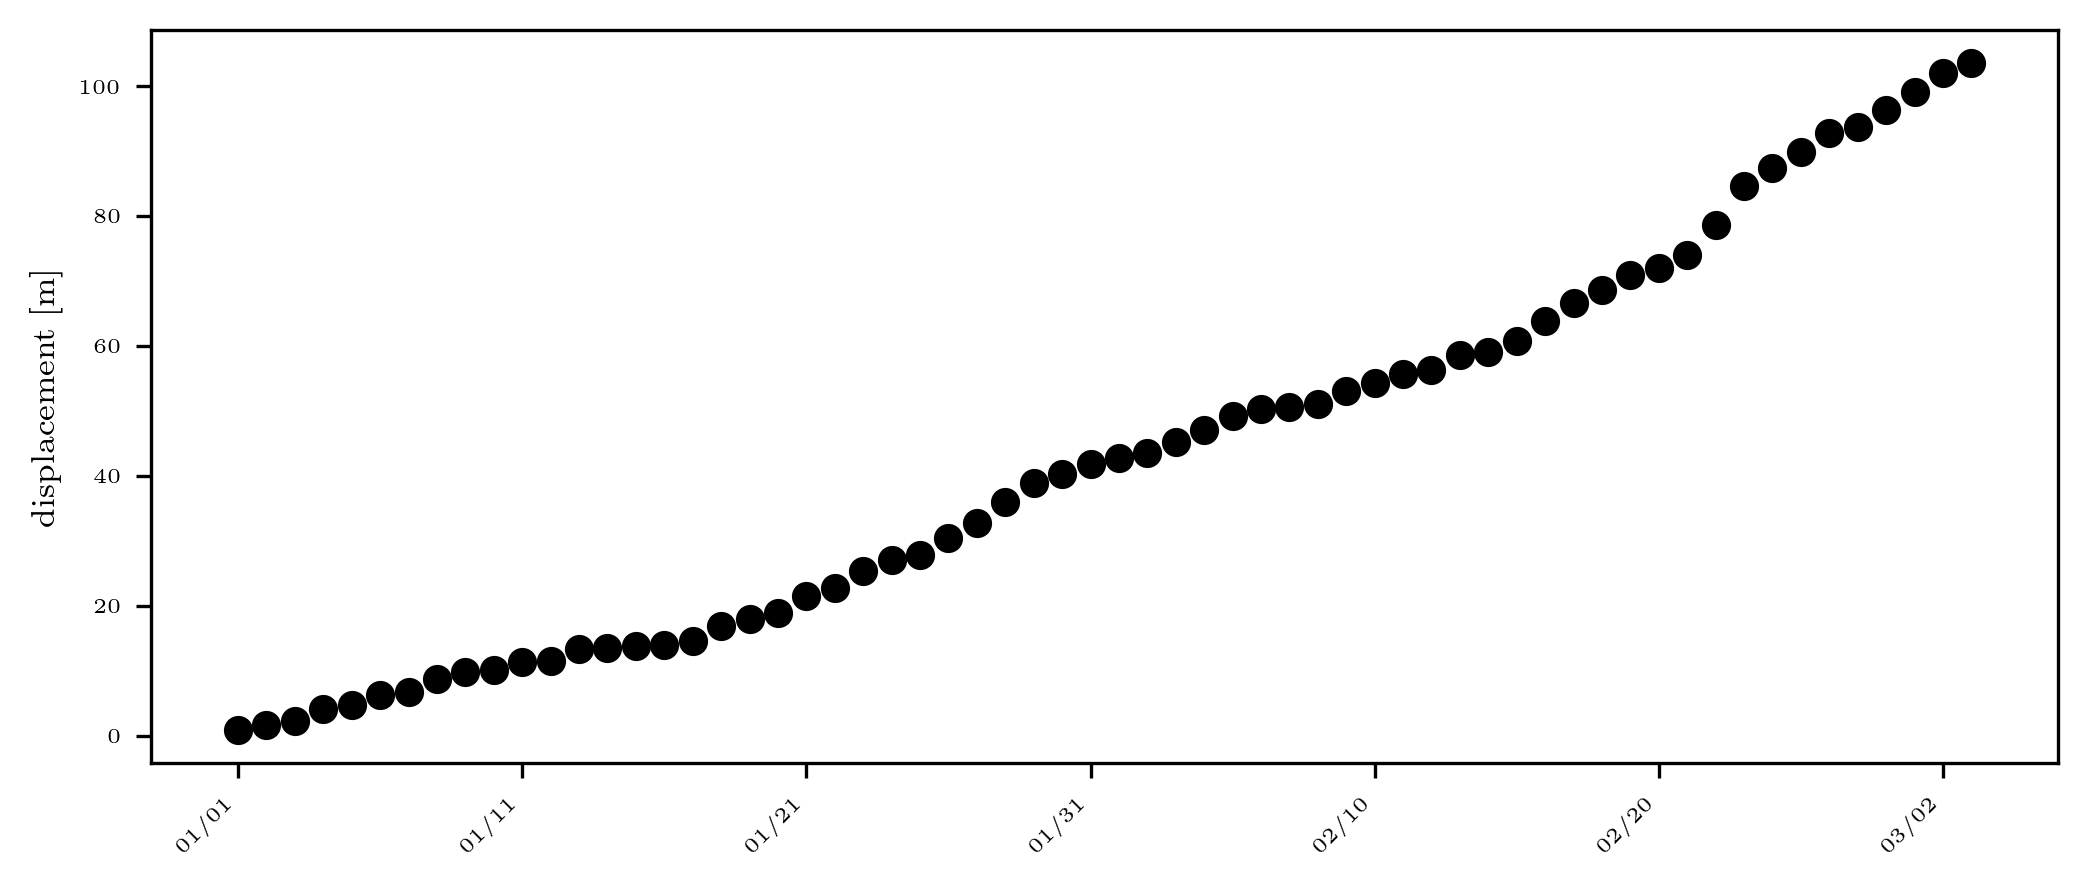

In [28]:
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

time = [dt.datetime.strptime(d,'%Y%m%d').date() for d in dates] #converting numerical dates to date time objecs

fig = plt.figure(figsize=(7, 3))
ax = plt.subplot(111)

ax.plot(mean_cumulative,'ok')

xfmt = mdates.DateFormatter('%m/%d') #specifying how to format/display the dates
ax.xaxis.set_major_formatter(xfmt) #telling the axis to format the dates by above format
# ax.set_xticks(time[1:]) #setting the xticks to be the input dates themselves
fig.autofmt_xdate(rotation=45) #rotating dates 45 degrees
ax.tick_params(axis='both', which='major', labelsize=5) #setting ticklabel sizes

# ax.set_xlabel('date')
ax.set_ylabel('displacement [m]')

fig.tight_layout()

# plt.savefig(
#     "/Volumes/Extreme Pro/Projects/EarthPIV/MudCreek/Figures/time_series"
#     + ".png",
#     format="PNG",
#     bbox_inches='tight')